In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from scipy.interpolate import interp1d

from src.utils import *
from src.rotor import Rotor
from src.bemt import bemt

# Blade Project
- Validate Geometry generation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


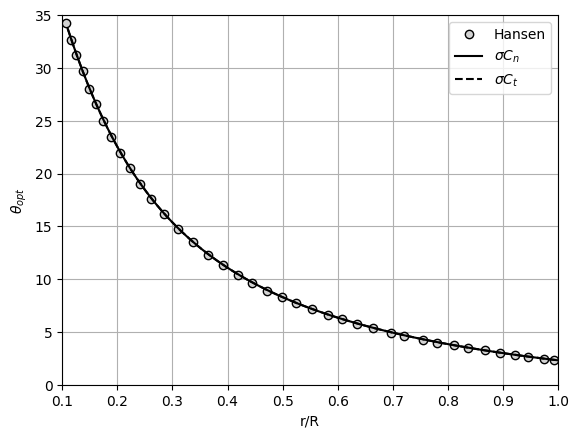

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


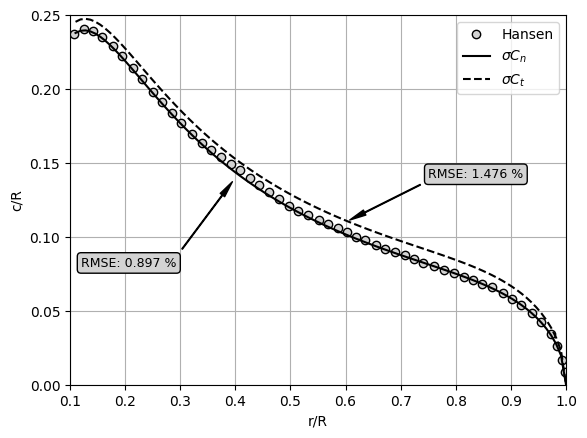

In [18]:
save_images = True

rotor = Rotor(number_of_blades=3, number_of_sections=100, tip_speed_ratio=6, alpha_opt=4, Cl_opt=0.8, Cd_opt=0.012)
rotor2 = Rotor(number_of_blades=3, number_of_sections=100, tip_speed_ratio=6, alpha_opt=4, Cl_opt=0.8, Cd_opt=0.012)

rotor.blade_design(r0_R=0.11, plot=False, solidity='Cn', filter_invalid_solidity=False)
rotor2.blade_design(r0_R=0.11, plot=False, solidity='Ct', filter_invalid_solidity=False)

chord_hansen_validate = np.loadtxt(validate_path.joinpath('chord_distribution_Hansen.dat'))
pitch_hansen_validate = np.loadtxt(validate_path.joinpath('pitch_distribution_Hansen.dat'))


# Compute Error
code_Cn = interp1d(rotor.sections['r_R'], rotor.sections['c_R'], kind='cubic')
code_Ct = interp1d(rotor2.sections['r_R'], rotor2.sections['c_R'], kind='cubic')
hansen = interp1d(chord_hansen_validate[:,0], chord_hansen_validate[:,1], kind='cubic')
error_Cn = (code_Cn(rotor.sections['r_R'][:-1]) - hansen(rotor.sections['r_R'][:-1]))**2
error_Ct = (code_Ct(rotor2.sections['r_R'][:-1]) - hansen(rotor2.sections['r_R'][:-1]))**2

error_Cn = np.sqrt(np.sum(error_Cn)/len(error_Cn)) * 100
error_Ct = np.sqrt(np.sum(error_Ct)/len(error_Ct)) * 100

# Pitch Angle Distribution

plt.figure(figsize=(6.4, 4.8))
plt.plot(pitch_hansen_validate[:,0], pitch_hansen_validate[:,1],'o', color = 'lightgray', markeredgecolor='black', label = 'Hansen')
plt.plot(rotor.sections['r_R'], rotor.sections['theta_opt'], 'k', label = r'$\sigma C_n$')
plt.plot(rotor2.sections['r_R'], rotor2.sections['theta_opt'], 'k--', label = r'$\sigma C_t$')

plt.xlabel('r/R')
plt.ylabel(r'$\theta_{opt}$')
plt.ylim(0,35)
plt.xlim(0.1, 1)


plt.legend()
plt.grid()
if save_images:
    plt.savefig(image_path.joinpath('pitch_angle_distribution_validate.eps'), format='eps')
plt.show()

# Chord Distribution
plt.figure(figsize=(6.4, 4.8))
plt.plot(chord_hansen_validate[:,0], chord_hansen_validate[:,1],'o',color='lightgray', markeredgecolor='black', label = 'Hansen')
plt.plot(rotor.sections['r_R'], rotor.sections['c_R']*rotor.sections['tip_correction'], 'k', label = r'$\sigma C_n$')
plt.plot(rotor2.sections['r_R'], rotor2.sections['c_R']*rotor2.sections['tip_correction'], 'k--', label = r'$\sigma C_t$')

# Adicionar a seta apontando para a primeira curva
arrow_width = 0.5
arrow_head_width = 4
plt.annotate(f'RMSE: {error_Cn:.3f} %', 
             xy=(0.4, 0.14),  # Posição da ponta da seta (x, y) no gráfico
             xytext=(0.12, 0.08),  # Posição do texto (x, y) no gráfico
             arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width),
             fontsize=9, bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3'))

# Adicionar a seta apontando para a segunda curva
plt.annotate(f'RMSE: {error_Ct:.3f} %', 
             xy=(0.6, 0.11),  # Posição da ponta da seta (x, y) no gráfico
             xytext=(0.75, 0.14),  # Posição do texto (x, y) no gráfico
             arrowprops=dict(facecolor='black', shrink=0.05, width=arrow_width, headwidth=arrow_head_width),
             fontsize=9, bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3') )

plt.xlabel('r/R')
plt.ylabel('c/R')
plt.ylim(0,0.25)
plt.xlim(0.1, 1)

plt.legend(loc = 1)
plt.grid()
if save_images:
    plt.savefig(image_path.joinpath('chord_distribution_validate.eps'), format='eps')
plt.show()


- Validate numerical relationships between $a$, $a'$ and $x$ 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


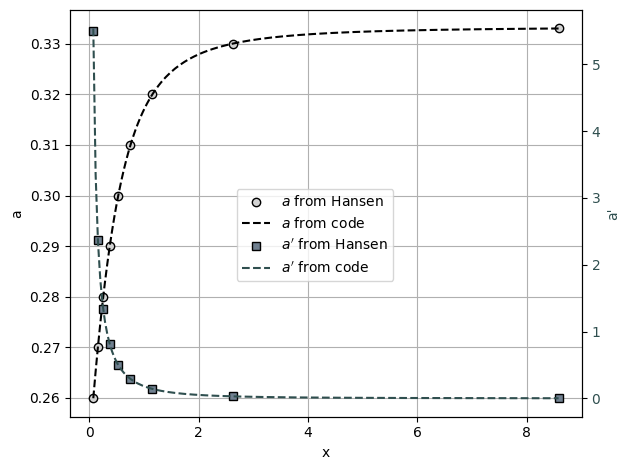

In [41]:
save_images = True

a, a_line, x= np.loadtxt(validate_path.joinpath('numerical_relationships_data.txt'), unpack=True)
rotor = Rotor(number_of_blades=2, number_of_sections=200, tip_speed_ratio=8.58, airfoil_name='s834')
rotor.load_airfoil_prop(plot=False)
rotor.blade_design(r0_R=0.0085, plot=False, filter_invalid_solidity=False, solidity='Cl')

# Criando a figura e o eixo
fig, ax1 = plt.subplots()

# Plotando a em função de x
ax1.set_xlabel('x')
ax1.set_ylabel('a', color='black')
ax1.plot(x, a, 'o', color='gray', markerfacecolor = 'lightgray', markeredgecolor='black', label=r"$a$ from Hansen")
ax1.plot(rotor.sections['x'], rotor.sections['a'], 'k--', label =r"$a$ from code")
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Criando um segundo eixo y para a' (compartilha o mesmo eixo x)
ax2 = ax1.twinx()
ax2.set_ylabel("a'", color='darkslategrey')
ax2.plot(x, a_line, 's', color='slategrey', markeredgecolor='black', label=r"$a'$ from Hansen")
ax2.plot(rotor.sections['x'], rotor.sections['a_line'], '--', color = 'darkslategrey', label = r"$a'$ from code")
ax2.tick_params(axis='y', labelcolor='darkslategrey')

# Exibindo o gráfico
fig.legend(loc = 'center')
fig.tight_layout()
if save_images:
    plt.savefig(image_path.joinpath('numerical_relationships.eps'), format = 'eps')
plt.show()

- Validate $C_P$ and $C_T$ curve for Optimum Blade design

In [34]:
TSR = np.arange(2, 10.25, 0.25)

CP = np.zeros((len(TSR), 2))
CT = np.zeros((len(TSR), 2))
sections_used = np.zeros(len(TSR))
rotor = Rotor(number_of_blades=2, number_of_sections=100, tip_speed_ratio=2, airfoil_name='s834')
rotor.load_airfoil_prop(plot=False)

for i, tsr in enumerate(TSR):
    rotor.tip_speed_ratio = tsr
    
    rotor.blade_design(r0_R=0.05, plot=False, filter_invalid_solidity=False)
    CP[i, 0] = rotor.CP_opt
    CT[i, 0] = rotor.CT_opt
    
    rotor.blade_design(r0_R=0.05, plot=False)
    CP[i, 1] = rotor.CP_opt
    CT[i, 1] = rotor.CT_opt
    sections_used[i] = rotor.number_of_sections_useful/rotor.number_of_sections
    print(f'Sections used: {rotor.number_of_sections_useful/rotor.number_of_sections * 100:.2f} %') 

Warning TSR = 2.0: solidity > 1 - This Points will be ignored
Sections used: 66.000 %
Warning TSR = 2.25: solidity > 1 - This Points will be ignored
Sections used: 71.000 %
Warning TSR = 2.5: solidity > 1 - This Points will be ignored
Sections used: 74.000 %
Warning TSR = 2.75: solidity > 1 - This Points will be ignored
Sections used: 77.000 %
Warning TSR = 3.0: solidity > 1 - This Points will be ignored
Sections used: 79.000 %
Warning TSR = 3.25: solidity > 1 - This Points will be ignored
Sections used: 81.000 %
Warning TSR = 3.5: solidity > 1 - This Points will be ignored
Sections used: 83.000 %
Warning TSR = 3.75: solidity > 1 - This Points will be ignored
Sections used: 84.000 %
Warning TSR = 4.0: solidity > 1 - This Points will be ignored
Sections used: 86.000 %
Warning TSR = 4.25: solidity > 1 - This Points will be ignored
Sections used: 87.000 %
Warning TSR = 4.5: solidity > 1 - This Points will be ignored
Sections used: 88.000 %
Warning TSR = 4.75: solidity > 1 - This Points wi

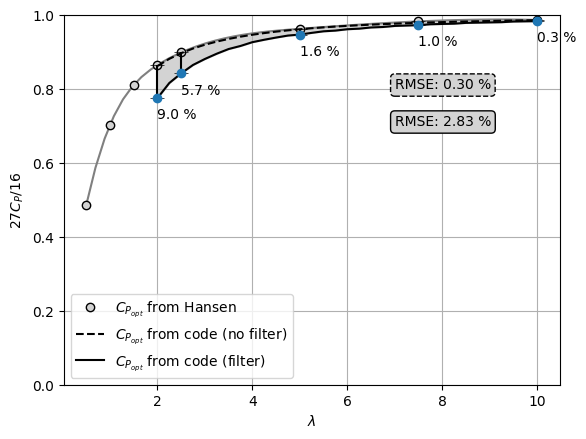

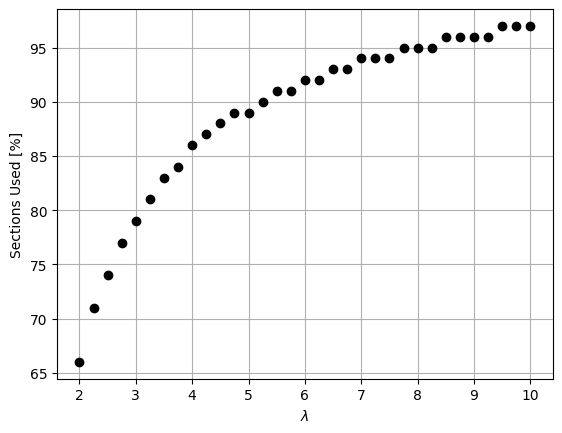

In [50]:
save_images = False

hansen_data = np.loadtxt(validate_path.joinpath('betz_limit_data.txt'))
hansen_interp = interp1d(hansen_data[:,0], hansen_data[:,1], kind='cubic')
tsr = np.linspace(hansen_data[0, 0], hansen_data[-1, 0])

CP_corr = 27*CP/16
code_interp_without_filter = interp1d(TSR, CP_corr[:, 0], kind='cubic')
code_interp_with_filter = interp1d(TSR, CP_corr[:, 1], kind='cubic')

# Cálculo do erro RMS
interpolated_hansen = hansen_interp(TSR)
error_rms_no_filter = np.sqrt(np.mean((interpolated_hansen - CP_corr[:, 0])**2))
error_rms_filter = np.sqrt(np.mean((interpolated_hansen - CP_corr[:, 1])**2))

# Cálculo do erro entre alguns pontos
points_to_errors = hansen_data[hansen_data[:,0] >= 2, 0]
error_rel_without_filter = np.abs(hansen_interp(points_to_errors) - code_interp_without_filter(points_to_errors))
error_rel_with_filter = np.abs(hansen_interp(points_to_errors) - code_interp_with_filter(points_to_errors))

yerr_without_filter = [np.zeros_like(error_rel_without_filter), error_rel_without_filter]
yerr_with_filter = [np.zeros_like(error_rel_with_filter), error_rel_with_filter]

# Plotting
plt.figure(figsize=(6.4, 4.8))
plt.plot(tsr, hansen_interp(tsr), '-', color = 'gray', markerfacecolor = 'lightgray', markeredgecolor='black')
plt.plot(hansen_data[:,0], hansen_data[:,1], 'o', color = 'gray', markerfacecolor = 'lightgray', markeredgecolor='black', label = '$C_{P_{opt}}$ from Hansen')

plt.plot(TSR, CP_corr[:, 0], 'k--', label = '$C_{P_{opt}}$ from code (no filter)')
plt.plot(TSR, CP_corr[:, 1], 'k', label = '$C_{P_{opt}}$ from code (filter)')

plt.annotate(f'RMSE: {error_rms_no_filter*100:.2f} %', xy=(7, 0.8), 
             fontsize=10, color='black', bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3', linestyle = '--') )
plt.annotate(f'RMSE: {error_rms_filter*100:.2f} %', xy=(7, 0.7), 
             fontsize=10, color='black', bbox=dict(facecolor='lightgray', boxstyle = 'round, pad=0.3') )

# Exibindo erros em alguns pontos
for i in range(len(points_to_errors)): 
    # plt.annotate(f'{error_rel_without_filter[i]*100:.1f} %', (points_to_errors[i], code_interp_without_filter(points_to_errors[i])), textcoords="offset points", xytext=(0,-15), ha='left', color='black')
    plt.annotate(f'{error_rel_with_filter[i]*100:.1f} %', (points_to_errors[i], code_interp_with_filter(points_to_errors[i])), textcoords="offset points", xytext=(0,-15), ha='left', color='black')
# plt.fill_between(TSR, CP_corr[:, 0], interpolated_hansen, color='lightgray')
plt.fill_between(TSR, CP_corr[:, 1], interpolated_hansen, color='lightgray')

# plt.errorbar(points_to_errors, code_interp_without_filter(points_to_errors) , yerr=yerr_without_filter, fmt='o', ecolor='black', capsize=5, uplims=False, capthick=0.5)
plt.errorbar(points_to_errors, code_interp_with_filter(points_to_errors) , yerr=yerr_with_filter, fmt='o', ecolor='black', capsize=5, uplims=False, capthick=0.5)


plt.xlabel(r'$\lambda$')
plt.ylabel(r'$27C_P/16$')
plt.ylim(0,1)

plt.grid()
plt.legend()

if save_images:
    plt.savefig(image_path.joinpath('validate_cp_for_blade_design_code.eps'), format = 'eps',)
plt.show()

plt.figure(figsize=(6.4, 4.8))
plt.plot(TSR, sections_used*100, 'ko')
plt.xlabel(r'$\lambda$')
plt.ylabel('Sections Used [%]')
plt.grid()
plt.show()

- Coefficients Extrapolation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


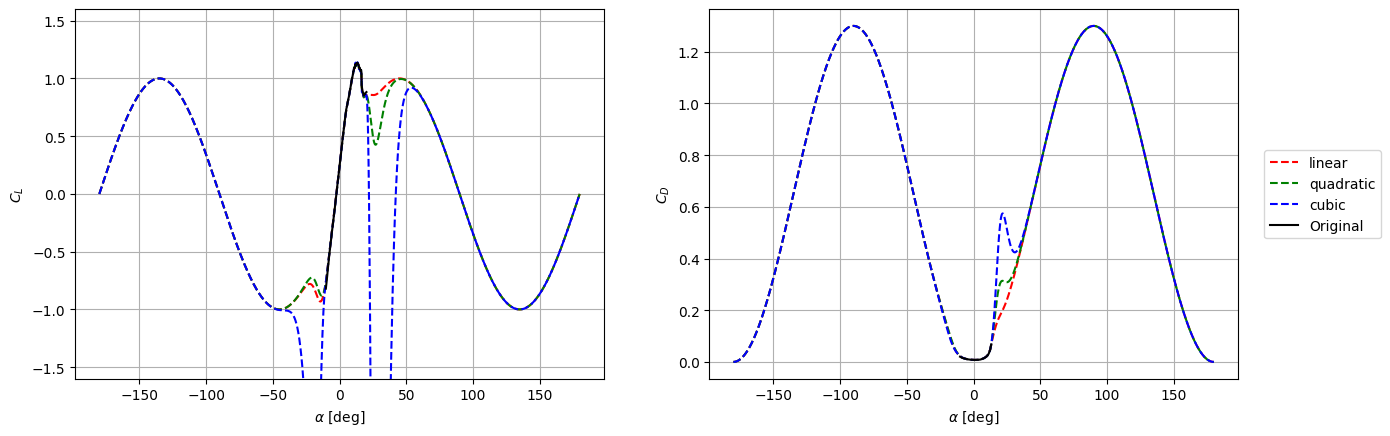

In [5]:
airfoil_name = 's834'
c_lift_drag = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_drg.txt'))
c_lift = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_lft.txt'))

re_drg = list(c_lift_drag.keys())[-1]
re_lft = list(c_lift.keys())[-2:]

Cd = c_lift_drag[re_drg][0][:, 2]
alpha_cd = c_lift_drag[re_drg][0][:, 0]

Cl = np.concatenate([c_lift[re][0][:,1] for re in re_lft])  
alpha_cl = np.concatenate([c_lift[re][0][:,0] for re in re_lft])  

arg = np.argsort(alpha_cl)
alpha_cl = np.sort(alpha_cl)
Cl = Cl[arg]

Cl_mat = np.concatenate((Cl.reshape(-1,1), alpha_cl.reshape(-1,1)), axis = 1)
Cd_mat = np.concatenate((Cd.reshape(-1,1), alpha_cd.reshape(-1,1)), axis = 1)

df_extra_linear = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='linear')
df_extra_quadratic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='quadratic')
df_extra_cubic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='cubic')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 4.8])

# ax1.plot(df_extra['alpha'],  df_extra['Cl'], 'r--', label = 'Extrapolation')
ax1.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cl'], 'r--',  label = 'linear')
ax1.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cl'], 'g--',  label = 'quadratic')
ax1.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cl'], 'b--',  label = 'cubic')
ax1.plot(alpha_cl,  Cl, 'k',  label = 'Original')

ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'$C_L$')
# ax1.set_xlim([-45, 45])
ax1.set_ylim([-1.6, 1.6])
# ax1.legend()
ax1.grid()

# ax2.plot(df_extra['alpha'],  df_extra['Cd'], 'r--', label = 'Extrapolation')
ax2.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cd'], 'r--')
ax2.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cd'], 'g--')
ax2.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cd'], 'b--')
ax2.plot(alpha_cd,  Cd, 'k')

ax2.set_xlabel(r'$\alpha$ [deg]')
ax2.set_ylabel(r'$C_D$')
ax2.grid()

fig.legend(bbox_to_anchor=(1, 0.6))
fig.savefig(image_path.joinpath('interp_effect.eps'), format = 'eps', bbox_inches = 'tight')
plt.show()

- Smooth transition function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


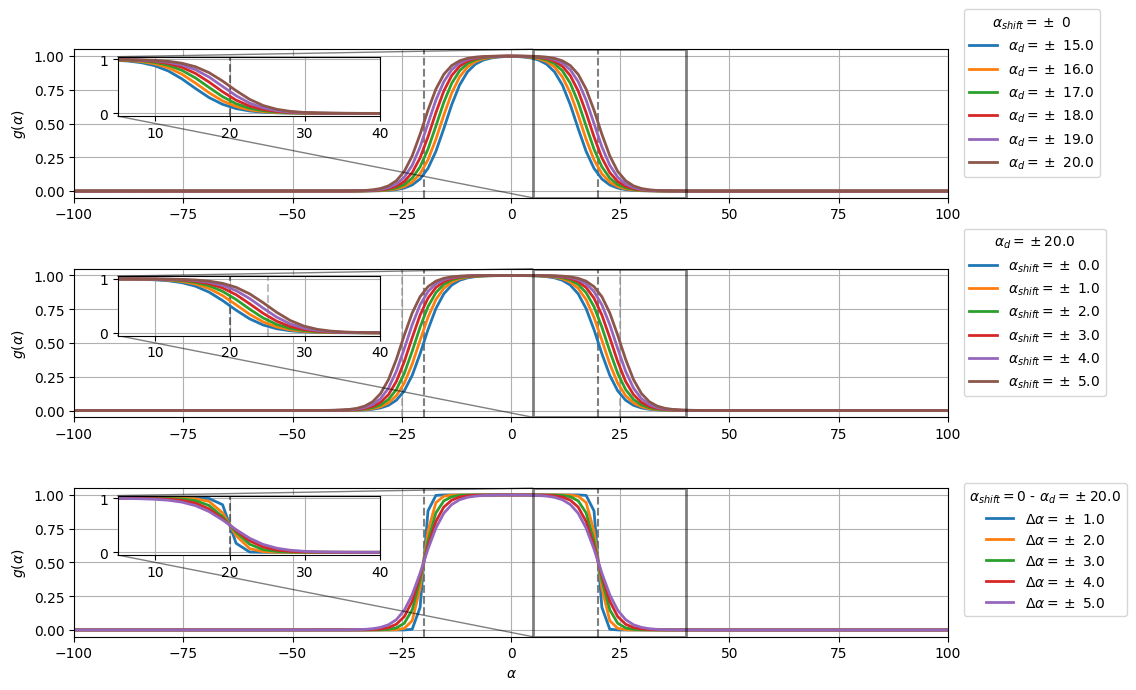

In [6]:
alpha_d = np.deg2rad(20)
alpha_shift = np.deg2rad(5)
delta_alpha = np.deg2rad(5)
alpha = np.linspace(-np.pi, np.pi, 200)


alpha_d_vec = np.deg2rad(np.arange(15, 21))
alpha_shift_vec = np.deg2rad(np.arange(0,6))
delta_alpha_vec = np.deg2rad(np.arange(1, 6))
alpha_vec = np.linspace(-np.pi, np.pi, 200)

g = lambda alpha, alpha_d = alpha_d, alpha_shift = alpha_shift, delta_alpha = delta_alpha: 0.5*(1+np.tanh((alpha_d + alpha_shift  - np.abs(alpha))/delta_alpha))

fig, axis = plt.subplots(3, 1, figsize = [10, 7])
fig.tight_layout(pad=3.0)
# fig.suptitle('Smooth Transition Function')
for i, ax in enumerate(axis):
    
    # zoomed plot
    axins = ax.inset_axes([0.05, 0.55, 0.3, 0.4])
    
    # Vertical Lines
    ax.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    ax.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    
    axins.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    axins.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    if i == 1:
        ax.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        ax.axvline(-np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
    
        axins.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        axins.axvline(-np.rad2deg(alpha_d +alpha_shift), linestyle='--', alpha = 0.5, color='gray')


    # Effect of change parameter in smooth transition function
    
    if i == 0:
        for alpha_d in alpha_d_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_d = alpha_d, alpha_shift=0), linewidth=2, label=r'$\alpha_d = \pm$ ' + f'{np.rad2deg(alpha_d):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_d=alpha_d, alpha_shift=0), linewidth=2)
            # ax.set_title('Smooth Transition function')
            title = r'$\alpha_{shift} = \pm$ 0'
    elif i == 1:
        for alpha_shift in alpha_shift_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift = alpha_shift), linewidth=2, label=r'$\alpha_{shift} = \pm$ ' + f'{np.rad2deg(alpha_shift):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=alpha_shift), linewidth=2)
            title = r'$\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    elif i == 2:
        for delta_alpha in delta_alpha_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha = delta_alpha), linewidth=2, label=r'$\Delta \alpha = \pm$ ' + f'{np.rad2deg(delta_alpha):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha=delta_alpha), linewidth=2)
            ax.set_xlabel(r'$\alpha$')
            title = r'$\alpha_{shift} = 0$ - $\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    # else:
    #     ax.plot(np.rad2deg(alpha), g(alpha), linewidth=2, color='black', label=r'$g(\alpha)$')


    ax.set_ylabel(r'$g(\alpha)$')
    # ax.set_xticks(np.arange(-180,190,10))
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.set_xlim([-100, 100])
    ax.legend(title = title, bbox_to_anchor=(1.01, 0.095))
    ax.grid()

    axins.set_xlim(5, 40)
    axins.grid()

    ax.indicate_inset_zoom(axins, linewidth=2, edgecolor="black")
fig.savefig(image_path.joinpath('transition_function.eps'), format='eps', bbox_inches='tight')
plt.show()


# BEMT

In [38]:
rotor = Rotor(number_of_blades=2, number_of_sections=100, tip_speed_ratio=7, airfoil_name='s834', tip_correction_model='')
rotor.load_airfoil_prop(plot=False)
rotor.blade_design(r0_R=0.3, plot=False)

# Without Drag losses and tip correction
results = bemt(rotor=rotor, TSR=np.arange(2, 14, 0.25), iter=500, tol=1e-3, tip_correction_model='', Cd_null=True)

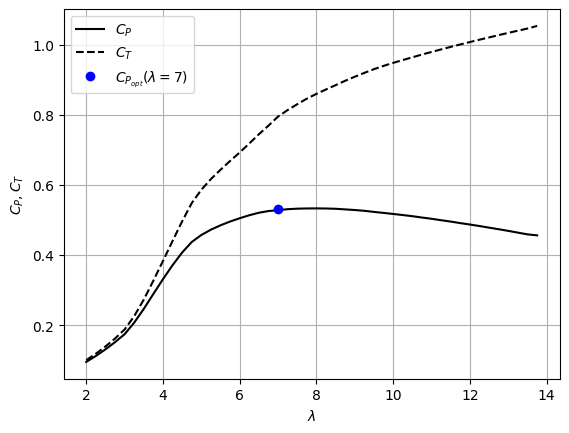

In [40]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(results.TSR, results.CP, 'k', label = r'$C_P$')
plt.plot(results.TSR, results.CT, 'k--', label = r'$C_T$')
plt.plot(rotor.tip_speed_ratio, rotor.CP_opt, 'bo', label = r'$C_{P_{opt}}(\lambda = 7)$')

# plt.title('CP and CT vs. Tip Speed Ratio')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$C_P, C_T$')

plt.grid()
plt.legend()
plt.show()